In [194]:
import pandas as pd
from utils import *
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import trange, tqdm
from time import sleep
from component_store import GeneticAlgorithmComponent
import numpy as np
from evaluation import *
import matplotlib.pyplot as plt

In [284]:
population_size = 10
brackets_per_individual = 3
test_brackets = 100

# Internals

In [285]:
features = best_features

results = run_pipe(2013, 2018, 2019, features)
train_acc, test_acc, clf = results
results
features

test_df = get_training_data([2019])
test_X = column_selector(test_df, features)
test_y = test_df['result']
test_X
test_year = 2019
df = pd.read_csv(f"{DATA_DIR}/cleaned_bracket_data.csv", index_col=0)
df = df[(df["year"] == test_year) & (df["round"] == 1)]
start_team_names = df[["team1", "team2"]].reset_index().melt(id_vars=['index'], value_vars=['team1', 'team2']).sort_values(["index", "variable"]).reset_index(drop=True)["value"]
start_team_names = pd.merge(start_team_names, df[["team1", "team1seed"]], how="left", left_on="value", right_on="team1").rename({"team1seed":"SEED"}, axis=1).drop("team1", axis=1)
start_team_names = pd.merge(start_team_names, df[["team2", "team2seed"]], how="left", left_on="value", right_on="team2").drop("team2", axis=1)
start_team_names.loc[start_team_names["SEED"].isna(), "SEED"] = start_team_names["team2seed"]
start_team_names = start_team_names.drop("team2seed", axis=1)

raw_brackets = generate_brackets_np(clf, features, start_team_names, test_year, (population_size * brackets_per_individual)+test_brackets)
print(raw_brackets.shape)

100%|██████████| 130/130 [00:28<00:00,  4.62it/s]

(130, 63)


In [286]:
brackets, test_set = raw_brackets[:-test_brackets], raw_brackets[-test_brackets:]
brackets = brackets.reshape((population_size, brackets_per_individual, 63))
brackets

array([[[1., 0., 1., ..., 0., 1., 1.],
        [0., 1., 0., ..., 1., 0., 0.],
        [1., 0., 1., ..., 0., 0., 1.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 1., ..., 0., 1., 1.],
        [1., 1., 0., ..., 0., 1., 0.]],

       [[1., 1., 1., ..., 0., 0., 0.],
        [1., 0., 1., ..., 1., 0., 1.],
        [1., 0., 1., ..., 0., 0., 1.]],

       ...,

       [[1., 1., 1., ..., 1., 1., 1.],
        [0., 0., 1., ..., 0., 1., 1.],
        [1., 0., 0., ..., 0., 1., 0.]],

       [[0., 1., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 0., ..., 1., 1., 0.]],

       [[1., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [1., 1., 1., ..., 1., 0., 0.]]])

In [287]:
init_pop = brackets.copy()
init_pop.shape

(10, 3, 63)

In [288]:
def eval_on_bracket(ind_true_bracket, init_pop):
    ind_true_bracket = np.tile(ind_true_bracket, [init_pop.shape[0], init_pop.shape[1], 1])
    results = init_pop == ind_true_bracket
    population_size, brackets_per_individual, _ = init_pop.shape
    preds = init_pop.copy()

    rounds =  [i + 2 for i in range(5)]
    round_lens = [16 // 2 ** (round - 2) for round in rounds]
    start_inds = [32, 32+16, 32+16+8, 32+16+8+4, 32+16+8+4+2]

    arr = []
    for i in range(6):
        arr = arr + [(2**i)]*(32//(2**i))
    point_values = np.tile(np.array(arr), (population_size, brackets_per_individual, 1))


    for round, round_len, start_ind in zip(rounds, round_lens, start_inds):
        for game in [start_ind + i for i in range(round_len)]:
            prereq_game_ind = (game-(2*round_len) + (game - start_ind) + (preds[:, :, game]).astype(int))#.reshape(2, 1, 1)
            prereq_results = results[:, :, prereq_game_ind][np.arange(population_size), :, np.arange(population_size), :][:, np.arange(brackets_per_individual), np.arange(brackets_per_individual)].reshape(results[:, :, game].shape)
            updated_results = np.logical_and(prereq_results, results[:, :, game])
            results[:, :, game] = updated_results

    fitness_per_individual = (point_values * results).sum(axis=2).max(axis=1)
    return fitness_per_individual

def fitness(init_pop, test_set):
    # TODO: vectorize this to improve efficiency for larger test sets
    return np.apply_along_axis(eval_on_bracket, 1, test_set, init_pop).mean(axis=0)

def softmax(x, em=1):
    em_x = x**em
    e_x = np.exp(em_x - em_x.max())
    return e_x / e_x.sum()

def selection(population, fitnesses, num_elites=0, emphasis=1):
    # print(softmax(fitnesses, emphasis))
    pop_size = population.shape[0]
    num_children_needed = population.shape[0] - num_elites
    # print(pop_size, num_children_needed)
    left_inds = np.random.choice(pop_size, num_children_needed, True, softmax(fitnesses, emphasis))
    right_inds = np.random.choice(pop_size, num_children_needed, True, softmax(fitnesses, emphasis))
    # print(left_inds)
    return population[left_inds], population[right_inds]

def combine(left_parents, right_parents):
    mask = np.random.binomial(1, 0.5, left_parents.shape)
    children = left_parents.copy()
    children[mask == 1] = right_parents[mask == 1]
    return children

def mutate(init_pop, mutation_rate):
    noise = np.random.binomial(1, mutation_rate, init_pop.shape)
    new_pop = np.logical_xor(init_pop, noise).astype(int)
    return new_pop

def generation(population, test_set, num_elites=3, emph=0.75, mr=1/1000):
    fitnesses = fitness(population, test_set)

    left_parents, right_parents = selection(population, fitnesses, num_elites=num_elites, emphasis=emph)
    children = mutate(combine(left_parents, right_parents), mutation_rate=mr)
    # print(children.shape)
    if num_elites > 0:
        elite_inds = np.argsort(fitnesses)[-num_elites:]
        elites = population[elite_inds]

        new_population = np.concatenate((children, elites), axis=0)
    else:
        new_population = children
    return new_population


# run GA

In [289]:
init_pop.shape

(10, 3, 63)

In [290]:
test_set.shape

(100, 63)

In [352]:
pop = init_pop.copy()
best_fits = np.zeros((1))
mean_fits = np.zeros((1))

In [353]:
num_elites = 1
emph = 0.75
mr=1/1000
test_subset_size = 40

In [357]:

num_gens = 2000
for i in trange(num_gens):
    test_subset_size = min(100, int(1/50 * i + 10))
    mr = 1/(i+100)
    test_subset = test_set[np.random.choice(np.arange(test_set.shape[0]), test_subset_size, False)]
    pop = generation(pop, test_subset, num_elites=num_elites, emph=emph, mr=mr)
    # print(fits[-1])
    if i % 100 == 0:
        fits = fitness(pop, test_set)
        best_fits = np.concatenate((best_fits, [fits.max()]))
        mean_fits = np.concatenate((mean_fits, [fits.mean()]))



100%|██████████| 2000/2000 [00:42<00:00, 47.45it/s]


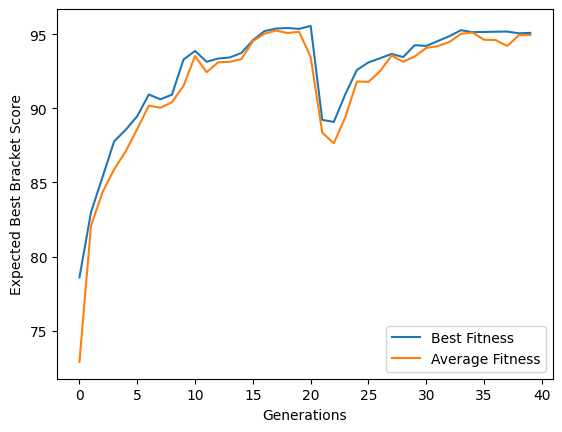

In [358]:

plt.plot(np.arange(len(best_fits) - 1), best_fits[1:], label="Best Fitness")
plt.plot(np.arange(len(best_fits) - 1), mean_fits[1:], label="Average Fitness")
plt.xlabel("Generations")
plt.ylabel("Expected Best Bracket Score")
plt.legend()
plt.show()

In [356]:
expected_fitness_rand = np.round(fitness(np.random.binomial(1, 0.5, (100, 10, 63)), test_set).mean(), 2)
expected_fitness_model = np.round(fitness(init_pop, test_set).mean(), 2)
expected_fitness_ga = np.round(fitness(pop, test_set).mean(), 2)
print(f"Expected Best Bracket Scores for {brackets_per_individual} Brackets:\n50/50 chance:\t\t{expected_fitness_rand}\nTrained model alone:\t{expected_fitness_model}\nGenetic Algorithm:\t{expected_fitness_ga}")

Expected Best Bracket Scores for 3 Brackets:
50/50 chance:		57.21
Trained model alone:	73.39
Genetic Algorithm:	95.5


In [332]:
test_set[np.random.choice(np.arange(test_set.shape[0]), 10, False)].shape

(10, 63)

In [333]:
fitness(init_pop, test_set).mean()

73.388

In [334]:
fitness(pop, test_set).mean()

91.35300000000002